In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Data normalization
## When?
- MinMax: 상한과 하한이 비교적 명확하고, 상한과 하한 사이에 값들이 어느정도 일정하게 분포하는 경우에 사용 
- Standardization: 데이터가 정규 분포를 따를 때 사용하면 효과적
- y변수는 normalization을 하는 것이 일반적임, 왜냐하면 normalization은 특정 x 변수가 y 예측에 큰 영향을 끼치는 것을 방지하거나, gradient descent를 이용하는 학습을 좀 더 빠르게 하기 위해서이기 때문

__어떤 scaling을 할 것인지도 결국에는 잘 선택해야 할 문제... 실험해봤을 때 어떤 모델을 사용하느냐에 따라, 어떤 상황이냐에 따라서 성능이 다 달라짐__ <br>
참고: scaling 관련하여 여러 실험을 수행해서 정리해 놓은 좋은 소스 <br>
- 원문: https://towardsdatascience.com/normalization-vs-standardization-quantitative-analysis-a91e8a79cebf#:~:text=Normalization%20typically%20means%20rescales%20the,of%201%20(unit%20variance).
- 한글 번역문: https://databreak.netlify.app/2019-05-02-Normalization_vs_Standardization-Quantitative%20analysis/

## How?
- train / test(valid) split 먼저 수행
- train에 대해서 scaling 방법 학습
- scaling한 train 데이터를 이용하여 모델 학습
- train 데이터로 학습한 scaling 방법을 이용하여 test(valid) 데이터 scaling
- scaling한 test(valid) 데이터를 이용하여 모델 학습

# Data: ToyotaCorolla.csv
- Age_08_04:   	 	Age in months as in August 2004
- KM:   		 	Accumulated Kilometers on odometer
- Fuel_Type:   		Fuel Type (Petrol, Diesel, CNG)
- HP:   			Horse Power
- Met_Color:   	 	Metallic Color?  (Yes=1, No=0)
- Automatic:   	 	Automatic ( (Yes=1, No=0)
- CC:   		 	Cylinder Volume in cubic centimeters
- Doors:   	 	Number of doors
- Quarterly_Tax:  	Quarterly road tax in EUROs
- Weight:   		Weight in Kilograms
- Price:   		 	Offer Price in EUROs

##### Data import

In [3]:
car_df = pd.read_csv('./data/ToyotaCorolla.csv')
print(car_df.shape)
car_df.head()

(1436, 39)


,Id,Model,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,Fuel_Type,HP,Met_Color,...,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Parking_Assistant,Tow_Bar
0,1,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13500,23,10,2002,46986,Diesel,90,1,...,1,1,0,0,0,1,0,0,0,0
1,2,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13750,23,10,2002,72937,Diesel,90,1,...,0,1,0,0,0,1,0,0,0,0
2,3,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13950,24,9,2002,41711,Diesel,90,1,...,0,1,0,0,0,1,0,0,0,0
3,4,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,14950,26,7,2002,48000,Diesel,90,0,...,0,1,0,0,0,1,0,0,0,0
4,5,TOYOTA Corolla 2.0 D4D HATCHB SOL 2/3-Doors,13750,30,3,2002,38500,Diesel,90,0,...,1,1,0,1,0,1,0,0,0,0


##### 실습용 데이터 선택
- 첫 1000개의 데이터만 모델 학습에 활용
- Predictors: 'Age_08_04', 'KM', 'Fuel_Type', 'HP', 'Met_Color', 'Automatic', 'CC', 'Doors', 'Quarterly_Tax', 'Weight'
- Outcome: 'Price'

In [4]:
predictors = ['Age_08_04', 'KM', 'Fuel_Type', 'HP', 'Met_Color', 'Automatic', 'CC', 
              'Doors', 'Quarterly_Tax', 'Weight']
outcome = 'Price'
car_df_test = pd.concat([car_df.loc[0:999, predictors], car_df.loc[0:999, outcome]], axis=1)
car_df_test.head()

,Age_08_04,KM,Fuel_Type,HP,Met_Color,Automatic,CC,Doors,Quarterly_Tax,Weight,Price
0,23,46986,Diesel,90,1,0,2000,3,210,1165,13500
1,23,72937,Diesel,90,1,0,2000,3,210,1165,13750
2,24,41711,Diesel,90,1,0,2000,3,210,1165,13950
3,26,48000,Diesel,90,0,0,2000,3,210,1165,14950
4,30,38500,Diesel,90,0,0,2000,3,210,1170,13750


##### categorical 변수 one-hot encoding

In [5]:
X = pd.get_dummies(car_df_test[predictors], drop_first=True)
y = car_df_test["Price"]
X.head()

,Age_08_04,KM,HP,Met_Color,Automatic,CC,Doors,Quarterly_Tax,Weight,Fuel_Type_Diesel,Fuel_Type_Petrol
0,23,46986,90,1,0,2000,3,210,1165,1,0
1,23,72937,90,1,0,2000,3,210,1165,1,0
2,24,41711,90,1,0,2000,3,210,1165,1,0
3,26,48000,90,0,0,2000,3,210,1165,1,0
4,30,38500,90,0,0,2000,3,210,1170,1,0


##### Normalization 전/후 살펴보기

Age_08_04

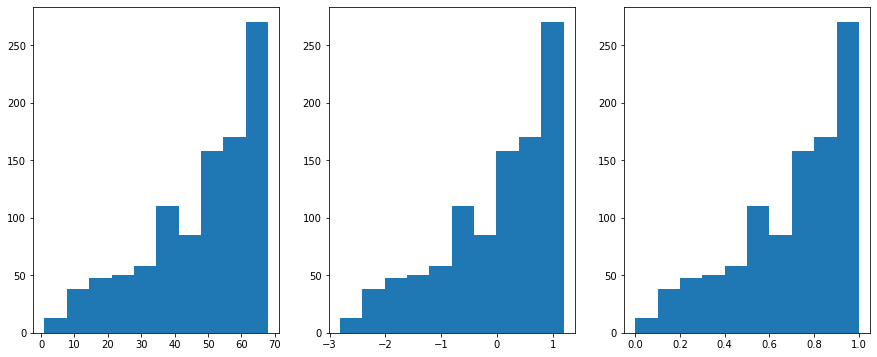

In [6]:
label = "Age_08_04"
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

#axes[0].hist(X.Age_08_04)
axes[0].hist(X[label])

scaler = preprocessing.StandardScaler()
#axes[1].hist(scaler.fit_transform(X[["Age_08_04"]]))
axes[1].hist(scaler.fit_transform(X[[label]]))

scaler = preprocessing.MinMaxScaler()
#axes[2].hist(scaler.fit_transform(X[["Age_08_04"]]))
axes[2].hist(scaler.fit_transform(X[[label]]))

plt.show()

KM

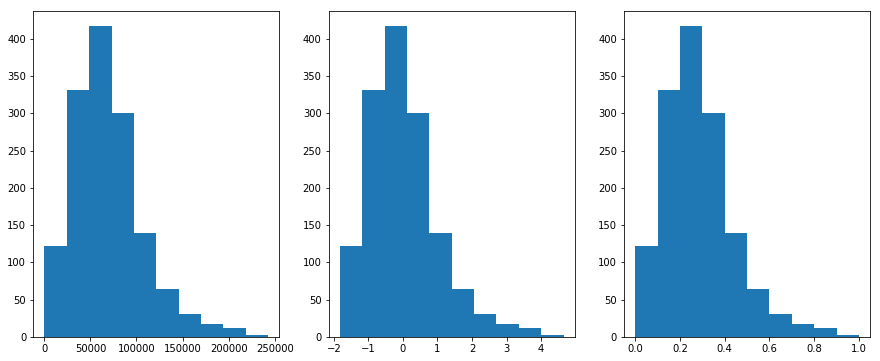

In [10]:
label = "KM"
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

#axes[0].hist(X.Age_08_04)
axes[0].hist(X[label])

scaler = preprocessing.StandardScaler()
#axes[1].hist(scaler.fit_transform(X[["Age_08_04"]]))
axes[1].hist(scaler.fit_transform(X[[label]]))

scaler = preprocessing.MinMaxScaler()
#axes[2].hist(scaler.fit_transform(X[["Age_08_04"]]))
axes[2].hist(scaler.fit_transform(X[[label]]))

plt.show()

Fuel_Type_Diesel

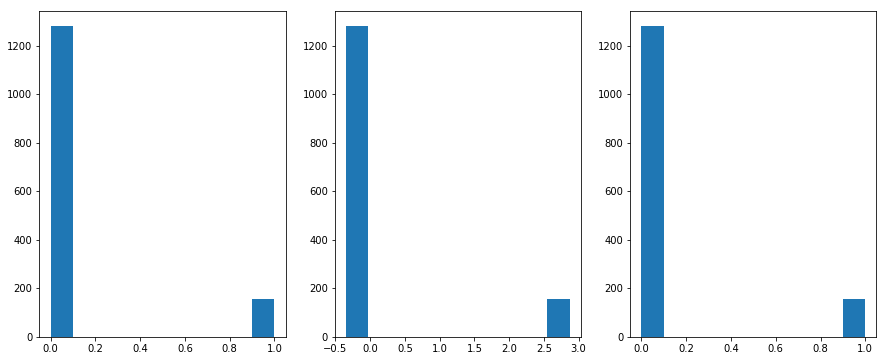

In [14]:
label = "Fuel_Type_Diesel"
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

#axes[0].hist(X.Age_08_04)
axes[0].hist(X[label])

scaler = preprocessing.StandardScaler()
#axes[1].hist(scaler.fit_transform(X[["Age_08_04"]]))
axes[1].hist(scaler.fit_transform(X[[label]]))

scaler = preprocessing.MinMaxScaler()
#axes[2].hist(scaler.fit_transform(X[["Age_08_04"]]))
axes[2].hist(scaler.fit_transform(X[[label]]))

plt.show()

아직 normalize 방법 달리 썼을 때 어떤지 확인해보기만 했음!

##### train_test_split을 이용하여 train set(60%)과 test set(40%)로 나누시오.

In [7]:
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

##### Normalization 규칙 학습

In [8]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(train_X)

MinMaxScaler()

##### Normalization

In [9]:
train_X_norm = scaler.transform(train_X)
valid_X_norm = scaler.transform(valid_X)

# Linear regression

In [10]:
lr = LinearRegression()
lr.fit(train_X_norm, train_y)

LinearRegression()

In [11]:
train_rmse = metrics.mean_squared_error(train_y, lr.predict(train_X_norm)) ** 0.5
valid_rmse = metrics.mean_squared_error(valid_y, lr.predict(valid_X_norm)) ** 0.5
print(f"train rmse: {train_rmse:.3f}")
print(f"valid rmse: {valid_rmse:.3f}")

train rmse: 1400.582
valid rmse: 1312.852


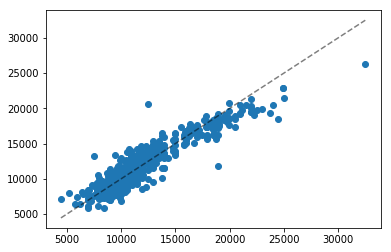

In [36]:
plt.scatter(train_y, lr.predict(train_X_norm))
plt.plot([train_y.min(), train_y.max()], [train_y.min(), train_y.max()], 'k--', alpha=0.5)

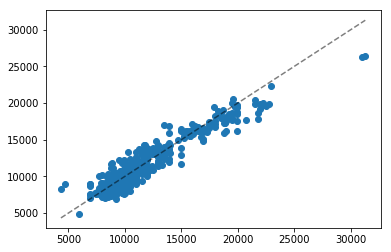

In [37]:
plt.scatter(valid_y, lr.predict(valid_X_norm))
plt.plot([valid_y.min(), valid_y.max()], [valid_y.min(), valid_y.max()], 'k--', alpha=0.5)

In [12]:
lr_coef_df = pd.DataFrame(lr.coef_, index=X.columns, columns=["lr_coef"])
lr_coef_df

,lr_coef
Age_08_04,-9430.166972
KM,-3853.444293
HP,4440.720567
Met_Color,84.281830
Automatic,416.781954
CC,260.727959
Doors,-101.315726
Quarterly_Tax,3597.085908
Weight,8018.807561
Fuel_Type_Diesel,1066.464681


# Regression with regularization

## Regularization?
- 회귀계수가 가질 수 있는 값에 제약조건을 부여하는 방법
- variance를 감소시켜 일반화 성능을 높임 (이 때, bias가 증가)
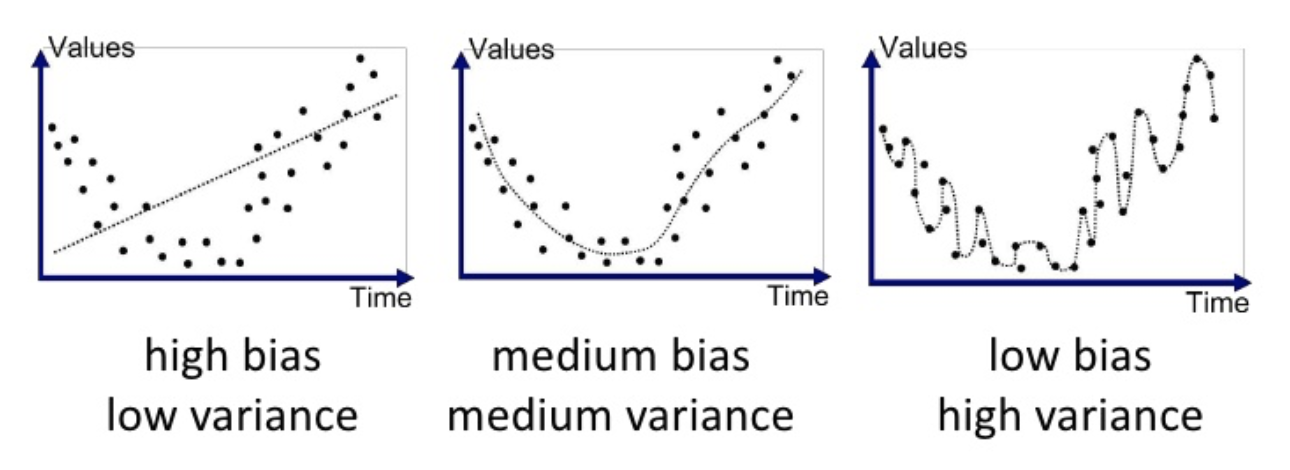

# simple LR vs. Ridge vs. Lasso
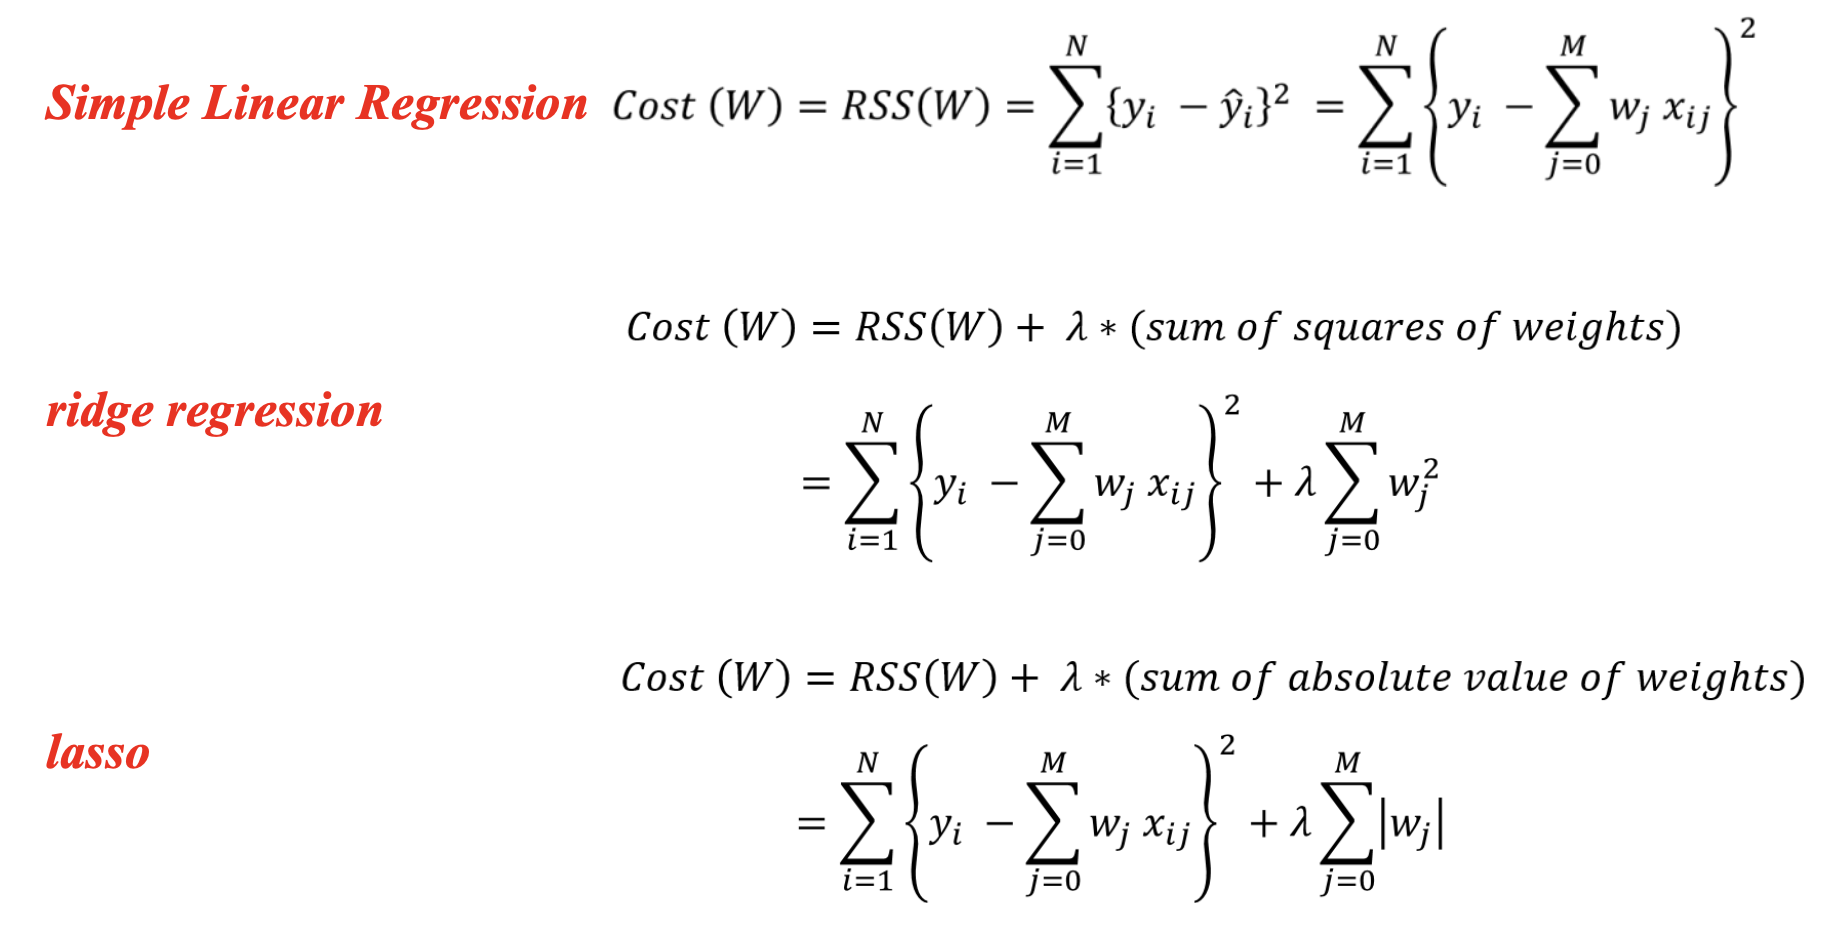

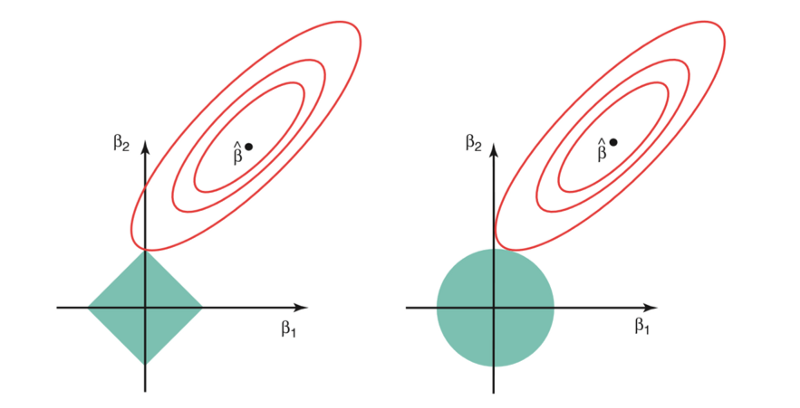

## Ridge regression

In [13]:
from sklearn.linear_model import Ridge

In [14]:
ridge = Ridge(alpha=1)
ridge.fit(train_X_norm, train_y)

train_rmse = metrics.mean_squared_error(train_y, ridge.predict(train_X_norm))**0.5
valid_rmse = metrics.mean_squared_error(valid_y, ridge.predict(valid_X_norm))**0.5

print(f"train: {train_rmse:.3f}")
print(f"test: {valid_rmse:.3f}")

train: 1408.331
test: 1359.229


In [15]:
ridge_coeff_df = pd.DataFrame(ridge.coef_, index=X.columns, columns=["ridge_coeff"])
ridge_coeff_df

,ridge_coeff
Age_08_04,-9439.458417
KM,-3944.437169
HP,4293.957999
Met_Color,82.891989
Automatic,483.650105
CC,367.261503
Doors,2.236070
Quarterly_Tax,3231.014548
Weight,6329.251237
Fuel_Type_Diesel,923.700029


##### alpha가 0.1, 1, 10일 때 비교

In [16]:
ridge_coeff_df_list = []
for a in [0.1, 1, 10]:
    ridge = Ridge(alpha=a)
    ridge.fit(train_X_norm, train_y)
    
    train_rmse = metrics.mean_squared_error(train_y, ridge.predict(train_X_norm))**0.5
    valid_rmse = metrics.mean_squared_error(valid_y, ridge.predict(valid_X_norm))**0.5
    ridge_coeff_df = pd.DataFrame(ridge.coef_, index=X.columns, columns=[f"ridge_{a}"])
    ridge_coeff_df_list.append(ridge_coeff_df)
    
    print("alpha: ", a)
    print(f"train: {train_rmse:.3f}")
    print(f"valid: {valid_rmse:.3f}")
    print("")

alpha:  0.1
train: 1400.700
valid: 1318.015

alpha:  1
train: 1408.331
valid: 1359.229

alpha:  10
train: 1591.757
valid: 1652.151



In [43]:
ridge_coeff_df_list[2]

,ridge_10
Age_08_04,-8270.032700
KM,-3695.182291
HP,2629.569061
Met_Color,158.834278
Automatic,536.289051
CC,265.175258
Doors,353.958968
Quarterly_Tax,1774.819990
Weight,3066.061349
Fuel_Type_Diesel,381.358523


##### 그래프를 그려서 비교

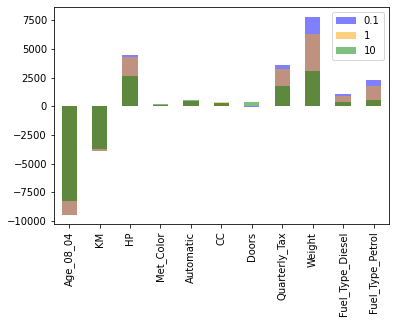

In [17]:
fig, ax = plt.subplots(1, 1)
colors = ["blue", "orange", "green"]
labels = [0.1, 1, 10]

for i in range(3):
    ridge_coeff_df_list[i].plot.bar(ax=ax, color=colors[i], alpha=0.5)
    
plt.legend(labels)
plt.show()

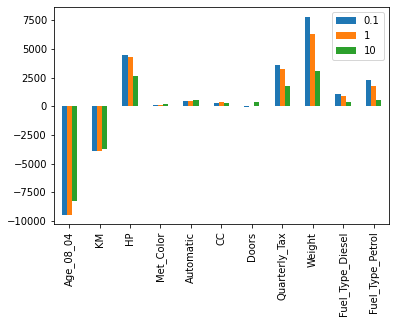

In [18]:
ridge_coef_total = pd.concat([ridge_coeff_df_list[0], 
                              ridge_coeff_df_list[1]], axis=1)
ridge_coef_total = pd.concat([ridge_coef_total, ridge_coeff_df_list[2]], axis=1)
ridge_coef_total.columns = ['0.1', '1', '10']
ridge_coef_total.plot.bar()
plt.show()

## Lasso regression

In [19]:
from sklearn.linear_model import Lasso

In [20]:
lasso = Lasso(alpha=1)
lasso.fit(train_X_norm, train_y)

train_rmse = metrics.mean_squared_error(train_y, lasso.predict(train_X_norm))**0.5
valid_rmse = metrics.mean_squared_error(valid_y, lasso.predict(valid_X_norm))**0.5

print(f"train: {train_rmse:.3f}")
print(f"test: {valid_rmse:.3f}")

train: 1400.862
test: 1317.602


In [21]:
lasso_coeff = pd.DataFrame(lasso.coef_, index=X.columns, columns=["lasso_coef"])
lasso_coeff

,lasso_coef
Age_08_04,-9462.837532
KM,-3819.329291
HP,4367.107364
Met_Color,76.767996
Automatic,409.535430
CC,0.000000
Doors,-85.785574
Quarterly_Tax,3465.023414
Weight,7933.461065
Fuel_Type_Diesel,933.041796


##### alpha가 0.1, 1, 10일 때 비교

In [23]:
lasso_coeff_df_list = []
for a in [0.1, 1, 10]:
    lasso = Lasso(alpha=a)
    lasso.fit(train_X_norm, train_y)
    
    train_rmse = metrics.mean_squared_error(train_y, lasso.predict(train_X_norm))**0.5
    valid_rmse = metrics.mean_squared_error(valid_y, lasso.predict(valid_X_norm))**0.5
    lasso_coeff_df = pd.DataFrame(lasso.coef_, index=X.columns, columns=[f"lasso_{a}"])
    lasso_coeff_df_list.append(lasso_coeff_df)
    
    print("alpha: ", a)
    print(f"train: {train_rmse:.3f}")
    print(f"valid: {valid_rmse:.3f}")
    print("")

alpha:  0.1
train: 1400.586
valid: 1313.265

alpha:  1
train: 1400.862
valid: 1317.602

alpha:  10
train: 1419.743
valid: 1382.395



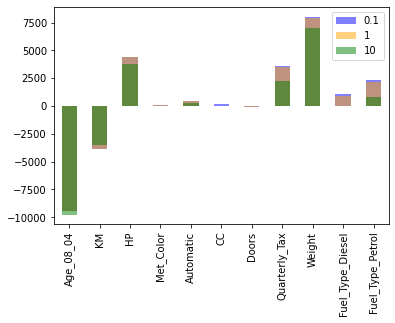

In [24]:
fig, ax = plt.subplots(1, 1)
colors = ["blue", "orange", "green"]
labels = [0.1, 1, 10]
for i in range(3):
    lasso_coeff_df_list[i].plot.bar(ax=ax, 
                                    color=colors[i], alpha=0.5)
plt.legend(labels)
plt.show()

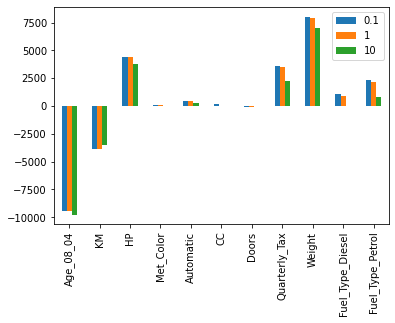

In [25]:
lasso_coef_total = pd.concat([lasso_coeff_df_list[0], 
                              lasso_coeff_df_list[1]], axis=1)
lasso_coef_total = pd.concat([lasso_coef_total, lasso_coeff_df_list[2]], axis=1)
lasso_coef_total.columns = ['0.1', '1', '10']
lasso_coef_total.plot.bar()
plt.show()

## LR vs. Ridge vs. Lasso

<AxesSubplot:>

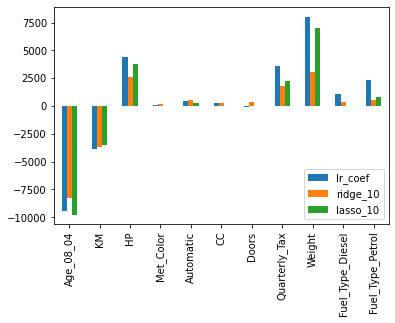

In [27]:
LR_RD_LAS = pd.concat([lr_coef_df, ridge_coeff_df_list[2],
                       lasso_coeff_df_list[2]], axis=1)
LR_RD_LAS.plot.bar()